In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

## Creating axillary data for greenland experiment

In [9]:
ds_alb = xr.open_dataset('albedo.nc')
ds_orog = xr.open_dataset('orography.nc')
ds_orog

<xarray.Dataset>
Dimensions:  (lat: 1024, lon: 2048)
Coordinates:
  * lat      (lat) float64 89.87 89.69 89.52 89.34 ... -89.52 -89.69 -89.87
  * lon      (lon) float64 0.0 0.1758 0.3516 0.5273 ... 359.3 359.5 359.6 359.8
Data variables:
    orog     (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Fri Feb 25 14:12:25 2022: ncks --baa=8 --ppc orog=7 orog_T6...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...

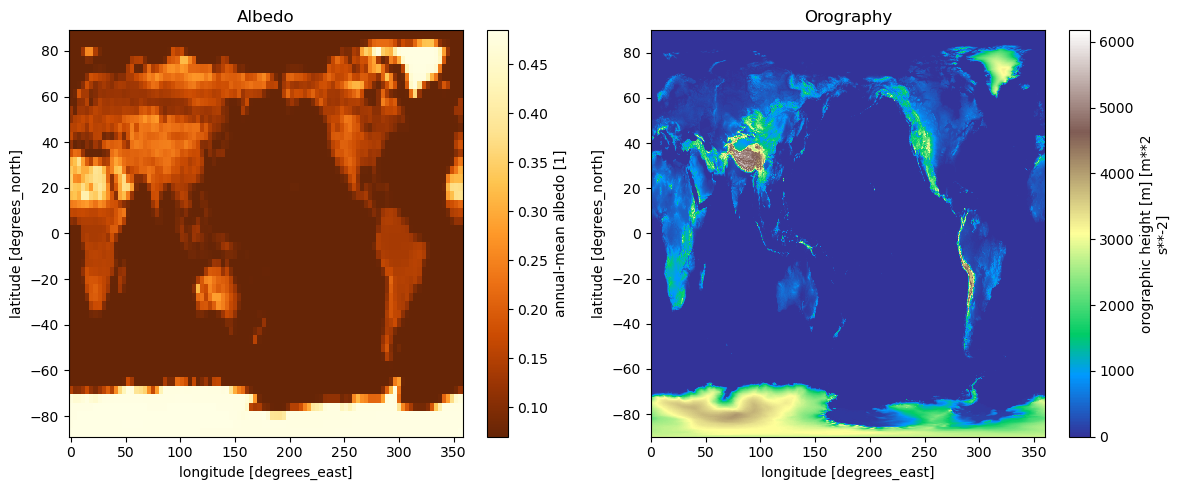

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ds_alb.alb.plot(ax=axs[0], cmap='YlOrBr_r')
axs[0].set_title('Albedo')

ds_orog.orog.plot(ax=axs[1], cmap='terrain')
axs[1].set_title('Orography')

plt.tight_layout()
plt.show()

<Axes: >

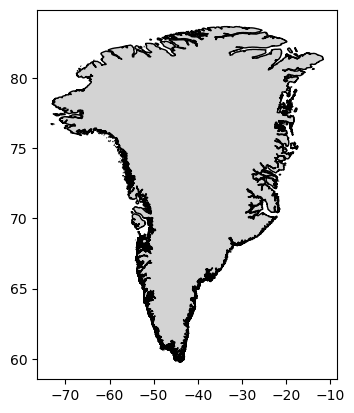

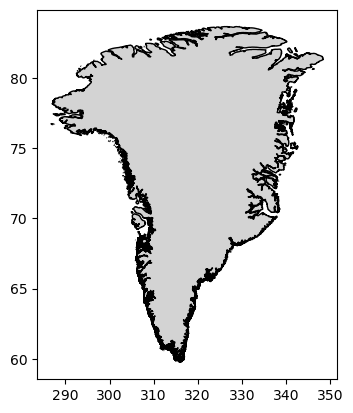

In [15]:
from shapely.ops import transform as shp_transform

greenland = gpd.read_file('/Users/ra933916@reading.ac.uk/Documents/UoR/SpeedyWeather/Data/Greenland_coast/Greenland_coast.shp')

greenland = greenland.to_crs(epsg=4326)  # Ensure the CRS is WGS84
greenland.plot(color='lightgrey', edgecolor='black')

# Convert Greenland geometry from (-180, 180) to (0, 360) longitude
def lon180_to_0360(geom):
    def shift_lon(x, y, z=None):
        x = np.asarray(x)
        x_new = x % 360
        if z is not None:
            return x_new, y, z
        return x_new, y
    return shp_transform(shift_lon, geom)

greenland_0360 = greenland.copy()
greenland_0360['geometry'] = greenland_0360['geometry'].apply(lon180_to_0360)

greenland_0360.plot(color='lightgrey', edgecolor='black')

/Users/ra933916@reading.ac.uk/miniconda3/envs/pcdmi_metrics_osx-64/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/Users/ra933916@reading.ac.uk/miniconda3/envs/pcdmi_metrics_osx-64/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


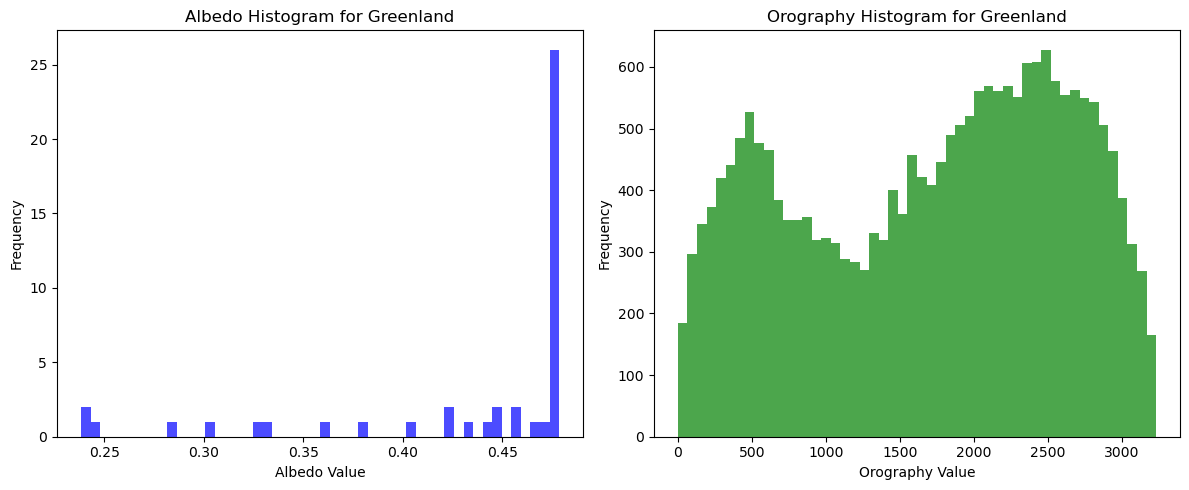

In [16]:
from rasterio import features
import affine

# Prepare affine transforms for both datasets
# ds_alb grid
lon_alb = ds_alb.lon.values
lat_alb = ds_alb.lat.values
res_lon_alb = (lon_alb[-1] - lon_alb[0]) / (len(lon_alb) - 1)
res_lat_alb = (lat_alb[-1] - lat_alb[0]) / (len(lat_alb) - 1)
transform_alb = affine.Affine.translation(lon_alb[0] - res_lon_alb / 2, lat_alb[0] - res_lat_alb / 2) * affine.Affine.scale(res_lon_alb, res_lat_alb)

# ds_orog grid
lon_orog = ds_orog.lon.values
lat_orog = ds_orog.lat.values
res_lon_orog = (lon_orog[-1] - lon_orog[0]) / (len(lon_orog) - 1)
res_lat_orog = (lat_orog[-1] - lat_orog[0]) / (len(lat_orog) - 1)
transform_orog = affine.Affine.translation(lon_orog[0] - res_lon_orog / 2, lat_orog[0] - res_lat_orog / 2) * affine.Affine.scale(res_lon_orog, res_lat_orog)

def rasterize_mask(gdf, ds, transform):
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = features.rasterize(
        shapes=shapes,
        out_shape=(ds.dims['lat'], ds.dims['lon']),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    return mask.astype(bool)

# Rasterize Greenland mask for both grids
greenland_mask_alb = rasterize_mask(greenland_0360, ds_alb, transform_alb)
greenland_mask_orog = rasterize_mask(greenland_0360, ds_orog, transform_orog)

# Extract data
greenland_albedo = ds_alb.alb.values[greenland_mask_alb]
greenland_orog = ds_orog.orog.values[greenland_mask_orog]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(greenland_albedo, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Albedo Histogram for Greenland')
axs[0].set_xlabel('Albedo Value')
axs[0].set_ylabel('Frequency')  
axs[1].hist(greenland_orog, bins=50, color='green', alpha=0.7)
axs[1].set_title('Orography Histogram for Greenland')
axs[1].set_xlabel('Orography Value')
axs[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Create copies of the datasets for experiments
ds_alb_greenland_exp = ds_alb.copy(deep=True)
ds_orog_greenland_exp = ds_orog.copy(deep=True)

# Reduce albedo by 50% in Greenland region
alb_vals = ds_alb_greenland_exp['alb'].values
alb_vals[greenland_mask_alb] *= 0.5
ds_alb_greenland_exp['alb'].values = alb_vals

# Reduce orography by 30% in Greenland region
orog_vals = ds_orog_greenland_exp['orog'].values
#orog_vals[greenland_mask_orog] *= 0.7
orog_vals[greenland_mask_orog] *= 0.2
ds_orog_greenland_exp['orog'].values = orog_vals

# Save to new NetCDF files
#ds_alb_greenland_exp.to_netcdf('albedo_greenland_30%_reduc_exp.nc')
ds_orog_greenland_exp.to_netcdf('orography_greenland_80%_reduc_exp.nc')

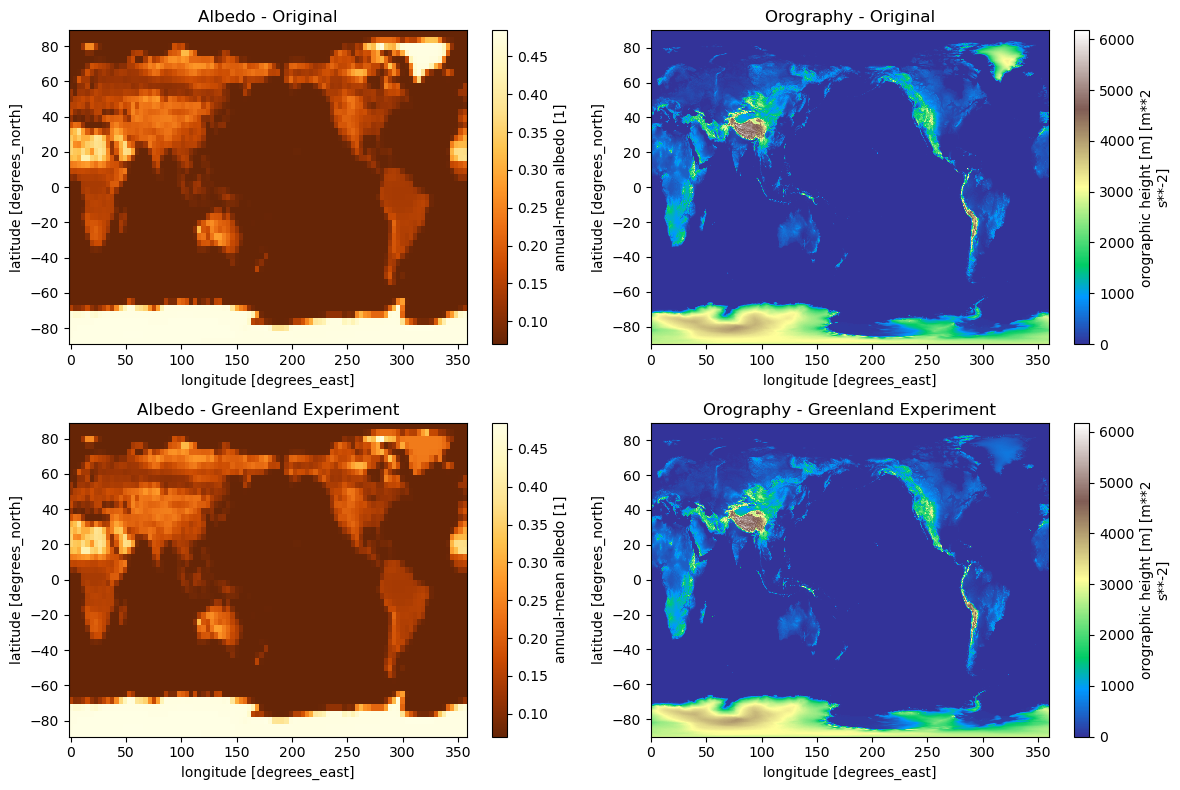

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

ds_alb.alb.plot(ax=axs[0, 0], cmap='YlOrBr_r')
axs[0, 0].set_title('Albedo - Original')

ds_orog.orog.plot(ax=axs[0, 1], cmap='terrain')
axs[0, 1].set_title('Orography - Original')

ds_alb_greenland_exp.alb.plot(ax=axs[1, 0], cmap='YlOrBr_r')
axs[1, 0].set_title('Albedo - Greenland Experiment')

ds_orog_greenland_exp.orog.plot(ax=axs[1, 1], cmap='terrain')
axs[1, 1].set_title('Orography - Greenland Experiment')
plt.tight_layout()
plt.show()

In [17]:
greenland_albedo

array([0.33007812, 0.32617188, 0.23828125, 0.40625   , 0.46875   ,
       0.4765625 , 0.4765625 , 0.47851562, 0.47851562, 0.47851562,
       0.47851562, 0.47851562, 0.47851562, 0.47460938, 0.43164062,
       0.28515625, 0.24707031, 0.44726562, 0.4765625 , 0.4765625 ,
       0.47851562, 0.47851562, 0.47851562, 0.47851562, 0.4765625 ,
       0.47460938, 0.44140625, 0.42382812, 0.47460938, 0.4765625 ,
       0.4765625 , 0.4765625 , 0.47460938, 0.47460938, 0.45507812,
       0.23925781, 0.45703125, 0.47460938, 0.47460938, 0.47460938,
       0.42382812, 0.3046875 , 0.4453125 , 0.47265625, 0.38085938,
       0.36132812], dtype=float32)

## Creating auxillary data for Amazon - Sahara experiment

In [5]:
ds_veg = xr.open_dataset('vegetation.nc')

ds_veg

<xarray.Dataset>
Dimensions:  (lon: 96, lat: 48)
Coordinates:
  * lon      (lon) float32 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * lat      (lat) float32 87.16 83.48 79.78 76.07 ... -79.78 -83.48 -87.16
Data variables:
    vegh     (lat, lon) float32 ...
    vegl     (lat, lon) float32 ...

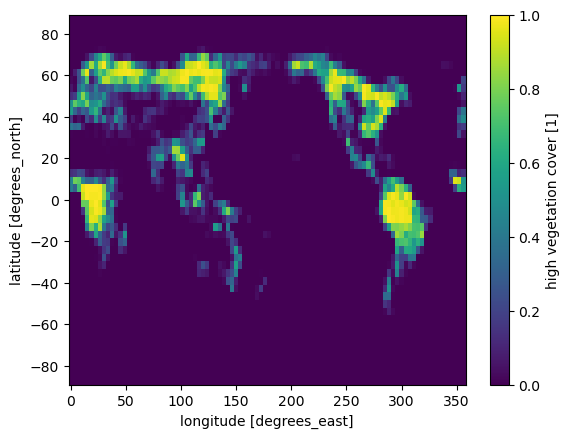

In [6]:
ds_veg.vegh.plot()

In [7]:
sahara = gpd.read_file('/Users/ra933916@reading.ac.uk/Documents/UoR/SpeedyWeather/Data/Saharadesert/lyr_78015c80_ca12_4d43_a18b_cbe84019e0df.shp')
amazon = gpd.read_file('/Users/ra933916@reading.ac.uk/Documents/UoR/SpeedyWeather/Data/AmazonBasinLimits-master/amazon_sensulatissimo_gmm_v1.shp')

<Axes: >

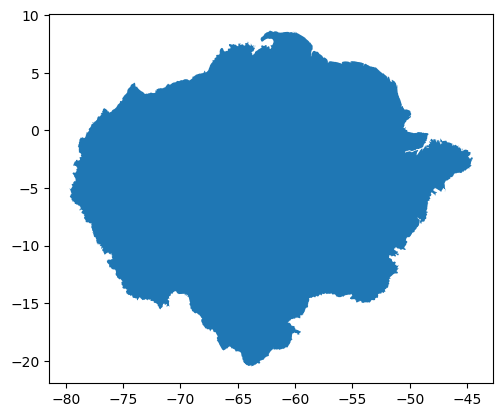

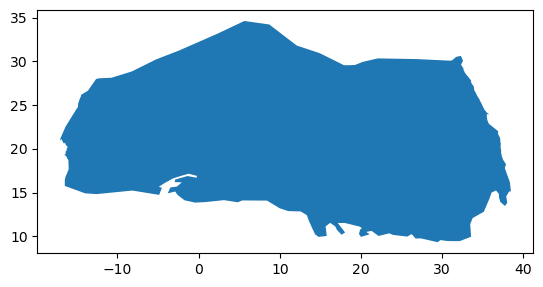

In [8]:
amazon.plot()
# Reproject sahara to WGS84 (EPSG:4326) to match amazon's CRS
if sahara.crs != amazon.crs:
    sahara = sahara.to_crs(amazon.crs)

sahara.plot()

In [9]:
from shapely.ops import transform as shp_transform

# Convert amazon and sahara geometries from 0/360 to -180/180 longitude
def lon360_to_180(geom):
    # Shift all longitudes from [0, 360] to [-180, 180]
    def shift_lon(x, y, z=None):
        x = np.asarray(x)
        x_new = ((x + 180) % 360) - 180
        if z is not None:
            return x_new, y, z
        return x_new, y
    return shp_transform(shift_lon, geom)

amazon_0360 = amazon.copy()
amazon_0360['geometry'] = amazon_0360['geometry'].apply(lon360_to_180)

sahara_0360 = sahara.copy()
sahara_0360['geometry'] = sahara_0360['geometry'].apply(lon360_to_180)

# Convert ds_veg from 0-360 longitude to -180 to 180 longitude
ds_veg_0360 = ds_veg.copy(deep=True)
# Shift longitude coordinate
ds_veg_0360 = ds_veg_0360.assign_coords(
    lon=(((ds_veg_0360.lon + 180) % 360) - 180)
)
# Sort by new longitude order
ds_veg_0360 = ds_veg_0360.sortby('lon')


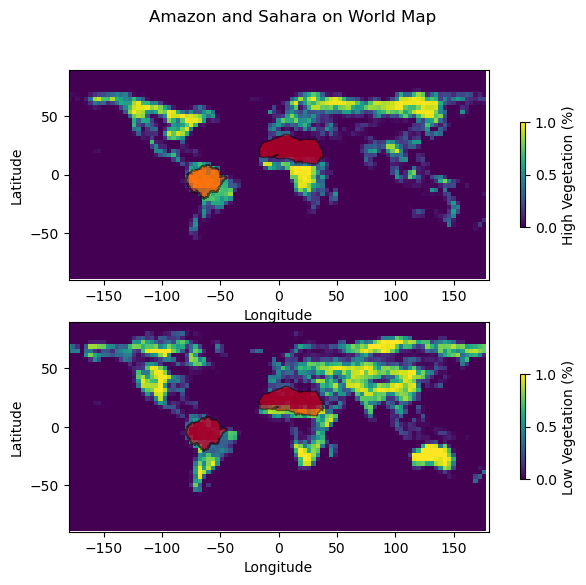

In [16]:
fig, axs = plt.subplots(nrows=2, figsize=(8, 6))
#world = gpd.read_file('/Users/ra933916@reading.ac.uk/Documents/UoR/SpeedyWeather/Data/ne_10m_admin_0_boundary_lines_land/ne_10m_admin_0_boundary_lines_land.shp')
#world.plot(ax=ax, color='lightgrey', edgecolor='black')

im1 = ds_veg_0360.vegh.plot(ax=axs[0], cmap='viridis', add_colorbar=False)
amazon_0360.plot(ax=axs[0], color='red', alpha=0.5, edgecolor='black')
sahara_0360.plot(ax=axs[0], color='red', alpha=0.5, edgecolor='black')

im2 = ds_veg_0360.vegl.plot(ax=axs[1], cmap='viridis', add_colorbar=False)
amazon_0360.plot(ax=axs[1], color='red', alpha=0.5, edgecolor='black')
sahara_0360.plot(ax=axs[1], color='red', alpha=0.5, edgecolor='black')

axs[0].set_xlim(-180, 180)
axs[0].set_ylim(-90, 90)
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')
axs[0].set_aspect('equal')
#axs[0].grid(True)

axs[1].set_xlim(-180, 180)
axs[1].set_ylim(-90, 90)
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')
axs[1].set_aspect('equal')
#axs[1].grid(True)

plt.colorbar(im1, ax=axs[0], orientation='vertical', label='High Vegetation (%)', shrink=0.5)
plt.colorbar(im2, ax=axs[1], orientation='vertical', label='Low Vegetation (%)', shrink=0.5)

#cbar1 = im1.colorbar
#cbar1.set_label('Leaf Area Index (LAI) - High Vegetation')
# To shrink the colorbar, recreate it with shrink parameter if needed

#cbar2 = im2.colorbar
#cbar2.set_label('Leaf Area Index (LAI) - Low Vegetation')
# To shrink the colorbar, recreate it with shrink parameter if needed

# Reduce the size of the colorbars (optional, but not via set_aspect)
# You can adjust colorbar size using fig.colorbar(..., shrink=...) if needed

fig.suptitle('Amazon and Sahara on World Map')
#axs[0].legend()
plt.show()

In the above figure, Amazon is majorly having high vegetation and sahara is missing the high vegetation

In [17]:
import affine

# Create affine transform for the xarray grid
lon = ds_veg_0360.lon.values
lat = ds_veg_0360.lat.values

# Assume regular grid
res_lon = (lon[-1] - lon[0]) / (len(lon) - 1)
res_lat = (lat[-1] - lat[0]) / (len(lat) - 1)

transform = affine.Affine.translation(lon[0] - res_lon / 2, lat[0] - res_lat / 2) * affine.Affine.scale(res_lon, res_lat)

from rasterio import features

def rasterize_mask(gdf, ds, transform):
    shapes = ((geom, 1) for geom in gdf.geometry)
    mask = features.rasterize(
        shapes=shapes,
        out_shape=(ds.dims['lat'], ds.dims['lon']),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    return mask.astype(bool)

amazon_mask = rasterize_mask(amazon_0360, ds_veg_0360, transform)
sahara_mask = rasterize_mask(sahara_0360, ds_veg_0360, transform)

amazon_vegh = ds_veg_0360.vegh.values[amazon_mask]
amazon_vegl = ds_veg_0360.vegl.values[amazon_mask]
sahara_vegh = ds_veg_0360.vegh.values[sahara_mask]
sahara_vegl = ds_veg_0360.vegl.values[sahara_mask]

/Users/ra933916@reading.ac.uk/miniconda3/envs/pcdmi_metrics_osx-64/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/Users/ra933916@reading.ac.uk/miniconda3/envs/pcdmi_metrics_osx-64/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


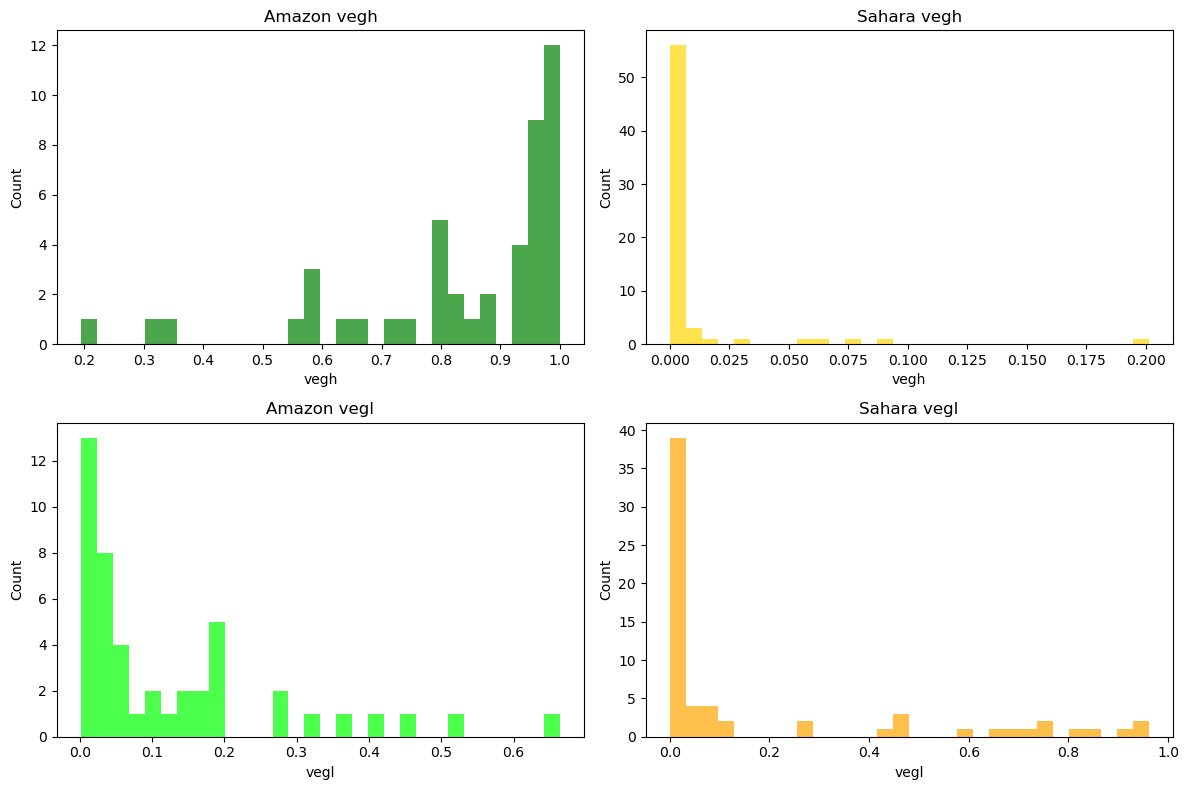

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

data = [
    (amazon_vegh, 'Amazon vegh', 'green', (0, 0), 'vegh'),
    (amazon_vegl, 'Amazon vegl', 'lime', (1, 0), 'vegl'),
    (sahara_vegh, 'Sahara vegh', 'gold', (0, 1), 'vegh'),
    (sahara_vegl, 'Sahara vegl', 'orange', (1, 1), 'vegl')
]

for arr, title, color, idx, xlabel in data:
    axs[idx].hist(arr, bins=30, color=color, alpha=0.7)
    axs[idx].set_title(title)
    axs[idx].set_xlabel(xlabel)
    axs[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [41]:
# Prepare three experimental datasets by swapping or replacing vegetation types

# 1. Swap Amazon and Sahara vegetation
ds_veg_swap = ds_veg_0360.copy(deep=True)
# Save original values for reference
vegh_amazon = ds_veg_0360.vegh.values.copy()
vegl_amazon = ds_veg_0360.vegl.values.copy()
vegh_sahara = ds_veg_0360.vegh.values.copy()
vegl_sahara = ds_veg_0360.vegl.values.copy()

# Swap Amazon and Sahara regions (only up to the minimum number of True values)
amazon_idx = np.where(amazon_mask.ravel())[0]
sahara_idx = np.where(sahara_mask.ravel())[0]

  # For the swap part below, keep as before

def create_flattened_arrays():
    # Calculate how many times Amazon fits into Sahara
    n_amazon = len(amazon_idx)
    n_sahara = len(sahara_idx)
    n_repeats = n_sahara // n_amazon
    n_leftover = n_sahara % n_amazon

    n_swap = n_amazon
    vegh_flat = ds_veg_0360['vegh'].values.ravel().copy()
    vegl_flat = ds_veg_0360['vegl'].values.ravel().copy()

    # Stuff multiple Amazons into Sahara
    if n_repeats > 0:
        for i in range(n_repeats):
            start = i * n_amazon
            end = start + n_amazon
            vegh_flat[sahara_idx[start:end]] = ds_veg_0360['vegh'].values.ravel()[amazon_idx]
            vegl_flat[sahara_idx[start:end]] = ds_veg_0360['vegl'].values.ravel()[amazon_idx]
    if n_leftover > 0:
        vegh_flat[sahara_idx[-n_leftover:]] = ds_veg_0360['vegh'].values.ravel()[amazon_idx[:n_leftover]]
        vegl_flat[sahara_idx[-n_leftover:]] = ds_veg_0360['vegl'].values.ravel()[amazon_idx[:n_leftover]]
    return vegh_flat, vegl_flat, n_swap

vegh_flat, vegl_flat, n_swap = create_flattened_arrays()
#vegh_flat = ds_veg_swap['vegh'].values.ravel()
#vegl_flat = ds_veg_swap['vegl'].values.ravel()

# Save original values for swapping
vegh_amazon_vals = ds_veg_0360['vegh'].values.ravel()[amazon_idx[:n_swap]].copy()
vegl_amazon_vals = ds_veg_0360['vegl'].values.ravel()[amazon_idx[:n_swap]].copy()
vegh_sahara_vals = ds_veg_0360['vegh'].values.ravel()[sahara_idx[:n_swap]].copy()
vegl_sahara_vals = ds_veg_0360['vegl'].values.ravel()[sahara_idx[:n_swap]].copy()

# Swap values
vegh_flat[amazon_idx[:n_swap]] = vegh_sahara_vals
vegh_flat[sahara_idx[:n_swap]] = vegh_amazon_vals
vegl_flat[amazon_idx[:n_swap]] = vegl_sahara_vals
vegl_flat[sahara_idx[:n_swap]] = vegl_amazon_vals

# Reshape back to original shape
ds_veg_swap['vegh'].values = vegh_flat.reshape(ds_veg_0360['vegh'].shape)
ds_veg_swap['vegl'].values = vegl_flat.reshape(ds_veg_0360['vegl'].shape)

# 2. Replace Amazon region with Sahara values (Sahara type in both)
ds_veg_sahara2 = ds_veg_0360.copy(deep=True)
vegh_amazon_vals = ds_veg_0360['vegh'].values.ravel()[sahara_idx[:n_swap]].copy()
vegl_amazon_vals = ds_veg_0360['vegl'].values.ravel()[sahara_idx[:n_swap]].copy()
vegh_sahara_vals = ds_veg_0360['vegh'].values.ravel()[sahara_idx[:n_swap]].copy()
vegl_sahara_vals = ds_veg_0360['vegl'].values.ravel()[sahara_idx[:n_swap]].copy()

vegh_flat, vegl_flat, n_swap = create_flattened_arrays()

# Swap values
vegh_flat[amazon_idx[:n_swap]] = vegh_amazon_vals
vegh_flat[sahara_idx[:n_swap]] = vegh_amazon_vals
vegl_flat[amazon_idx[:n_swap]] = vegl_sahara_vals
vegl_flat[sahara_idx[:n_swap]] = vegl_sahara_vals

# Replace Amazon region with Sahara values (Sahara type in both)
ds_veg_sahara2['vegh'].values = vegh_flat.reshape(ds_veg_0360['vegh'].shape)
ds_veg_sahara2['vegl'].values = vegl_flat.reshape(ds_veg_0360['vegl'].shape)

# 3. Replace Sahara region with Amazon max values (Amazon type in both)
ds_veg_amazon2 = ds_veg_0360.copy(deep=True)
vegh_amazon_vals = ds_veg_0360['vegh'].values.ravel()[amazon_idx[:n_swap]].copy()
vegl_amazon_vals = ds_veg_0360['vegl'].values.ravel()[amazon_idx[:n_swap]].copy()
vegh_sahara_vals = ds_veg_0360['vegh'].values.ravel()[amazon_idx[:n_swap]].copy()
vegl_sahara_vals = ds_veg_0360['vegl'].values.ravel()[amazon_idx[:n_swap]].copy()

vegh_flat, vegl_flat, n_swap = create_flattened_arrays()

vegh_flat[amazon_idx[:n_swap]] = vegh_amazon_vals
vegl_flat[amazon_idx[:n_swap]] = vegl_amazon_vals
vegh_flat[sahara_idx[:n_swap]] = vegh_sahara_vals
vegl_flat[sahara_idx[:n_swap]] = vegl_sahara_vals

# Swap values
ds_veg_amazon2['vegh'].values = vegh_flat.reshape(ds_veg_0360['vegh'].shape)
ds_veg_amazon2['vegl'].values = vegl_flat.reshape(ds_veg_0360['vegl'].shape)


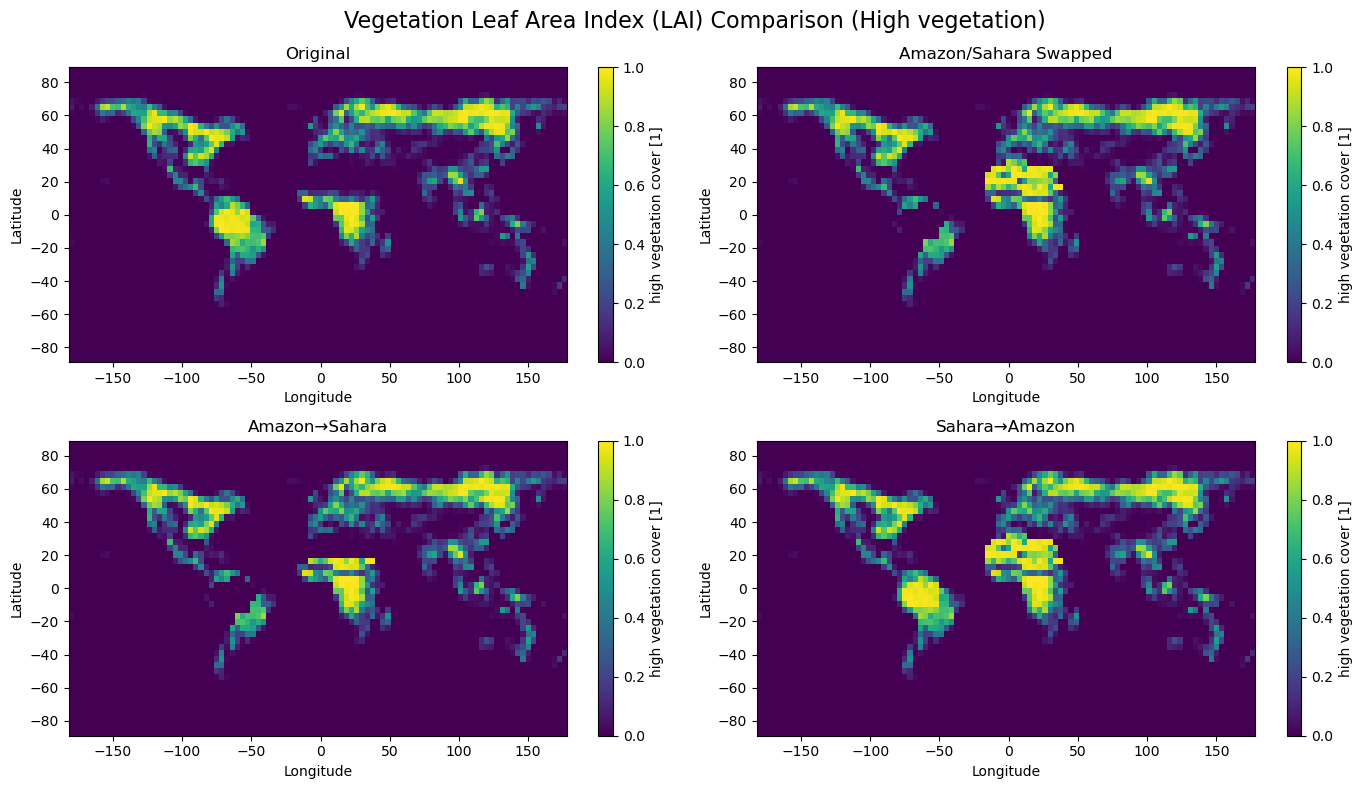

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

datasets = [
    (ds_veg_0360, 'Original'),
    (ds_veg_swap, 'Amazon/Sahara Swapped'),
    (ds_veg_sahara2, 'Amazon→Sahara'),
    (ds_veg_amazon2, 'Sahara→Amazon')
]

for ax, (ds, title) in zip(axs.flat, datasets):
    ds.vegh.plot(ax=ax, cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

fig.suptitle('Vegetation Leaf Area Index (LAI) Comparison (High vegetation)', fontsize=16)

plt.tight_layout()
plt.show()

In [43]:
def convert_lon_to_0360(ds):
    ds_new = ds.copy(deep=True)
    # Convert longitude from [-180, 180] to [0, 360)
    lon_0360 = (ds_new.lon % 360)
    ds_new = ds_new.assign_coords(lon=lon_0360)
    ds_new = ds_new.sortby('lon')
    return ds_new

# Convert and save each dataset
#convert_lon_to_0360(ds_veg_0360).to_netcdf('vegetation_original_exp.nc')
convert_lon_to_0360(ds_veg_swap).to_netcdf('vegetation_swap_exp.nc')
convert_lon_to_0360(ds_veg_sahara2).to_netcdf('vegetation_sahara2_exp.nc')
convert_lon_to_0360(ds_veg_amazon2).to_netcdf('vegetation_amazon2_exp.nc')

In [47]:
# 1. Open the albedo dataset (assuming file is named 'albedo.nc' and structure is similar to vegetation)
ds_alb = xr.open_dataset('albedo.nc')

# 2. Convert longitude from 0-360 to -180 to 180, as done for vegetation
ds_alb_0360 = ds_alb.copy(deep=True)
ds_alb_0360 = ds_alb_0360.assign_coords(
    lon=(((ds_alb_0360.lon + 180) % 360) - 180)
)
ds_alb_0360 = ds_alb_0360.sortby('lon')

# 3. Prepare masks for Amazon and Sahara (reuse amazon_mask and sahara_mask, assuming same grid)
# If the grid is different, you need to rasterize again, but here we assume it's the same.

# 4. Get flat indices for Amazon and Sahara
amazon_idx = np.where(amazon_mask.ravel())[0]
sahara_idx = np.where(sahara_mask.ravel())[0]

def create_flattened_arrays_alb(ds_alb_0360, amazon_idx, sahara_idx):
    n_amazon = len(amazon_idx)
    n_sahara = len(sahara_idx)
    n_repeats = n_sahara // n_amazon
    n_leftover = n_sahara % n_amazon
    n_swap = n_amazon
    alb_flat = ds_alb_0360['alb'].values.ravel().copy()
    # Stuff multiple Amazons into Sahara
    if n_repeats > 0:
        for i in range(n_repeats):
            start = i * n_amazon
            end = start + n_amazon
            alb_flat[sahara_idx[start:end]] = ds_alb_0360['alb'].values.ravel()[amazon_idx]
    if n_leftover > 0:
        alb_flat[sahara_idx[-n_leftover:]] = ds_alb_0360['alb'].values.ravel()[amazon_idx[:n_leftover]]
    return alb_flat, n_swap

# 5. Generate three experimental datasets

# 1. Swap Amazon and Sahara albedo
ds_alb_swap = ds_alb_0360.copy(deep=True)
alb_flat, n_swap = create_flattened_arrays_alb(ds_alb_0360, amazon_idx, sahara_idx)
alb_amazon_vals = ds_alb_0360['alb'].values.ravel()[amazon_idx[:n_swap]].copy()
alb_sahara_vals = ds_alb_0360['alb'].values.ravel()[sahara_idx[:n_swap]].copy()
alb_flat[amazon_idx[:n_swap]] = alb_sahara_vals
alb_flat[sahara_idx[:n_swap]] = alb_amazon_vals
ds_alb_swap['alb'].values = alb_flat.reshape(ds_alb_0360['alb'].shape)

# 2. Replace Amazon region with Sahara values (Sahara type in both)
ds_alb_sahara2 = ds_alb_0360.copy(deep=True)
alb_flat, n_swap = create_flattened_arrays_alb(ds_alb_0360, amazon_idx, sahara_idx)
alb_flat[amazon_idx[:n_swap]] = alb_sahara_vals
alb_flat[sahara_idx[:n_swap]] = alb_sahara_vals
ds_alb_sahara2['alb'].values = alb_flat.reshape(ds_alb_0360['alb'].shape)

# 3. Replace Sahara region with Amazon values (Amazon type in both)
ds_alb_amazon2 = ds_alb_0360.copy(deep=True)
alb_flat, n_swap = create_flattened_arrays_alb(ds_alb_0360, amazon_idx, sahara_idx)
alb_flat[amazon_idx[:n_swap]] = alb_amazon_vals
alb_flat[sahara_idx[:n_swap]] = alb_amazon_vals
ds_alb_amazon2['alb'].values = alb_flat.reshape(ds_alb_0360['alb'].shape)

# 6. (Optional) Save the new datasets in 0-360 longitude format
def convert_lon_to_0360(ds):
    ds_new = ds.copy(deep=True)
    lon_0360 = (ds_new.lon % 360)
    ds_new = ds_new.assign_coords(lon=lon_0360)
    ds_new = ds_new.sortby('lon')
    return ds_new

convert_lon_to_0360(ds_alb_swap).to_netcdf('albedo_swap_exp.nc')
convert_lon_to_0360(ds_alb_sahara2).to_netcdf('albedo_sahara2_exp.nc')
convert_lon_to_0360(ds_alb_amazon2).to_netcdf('albedo_amazon2_exp.nc')

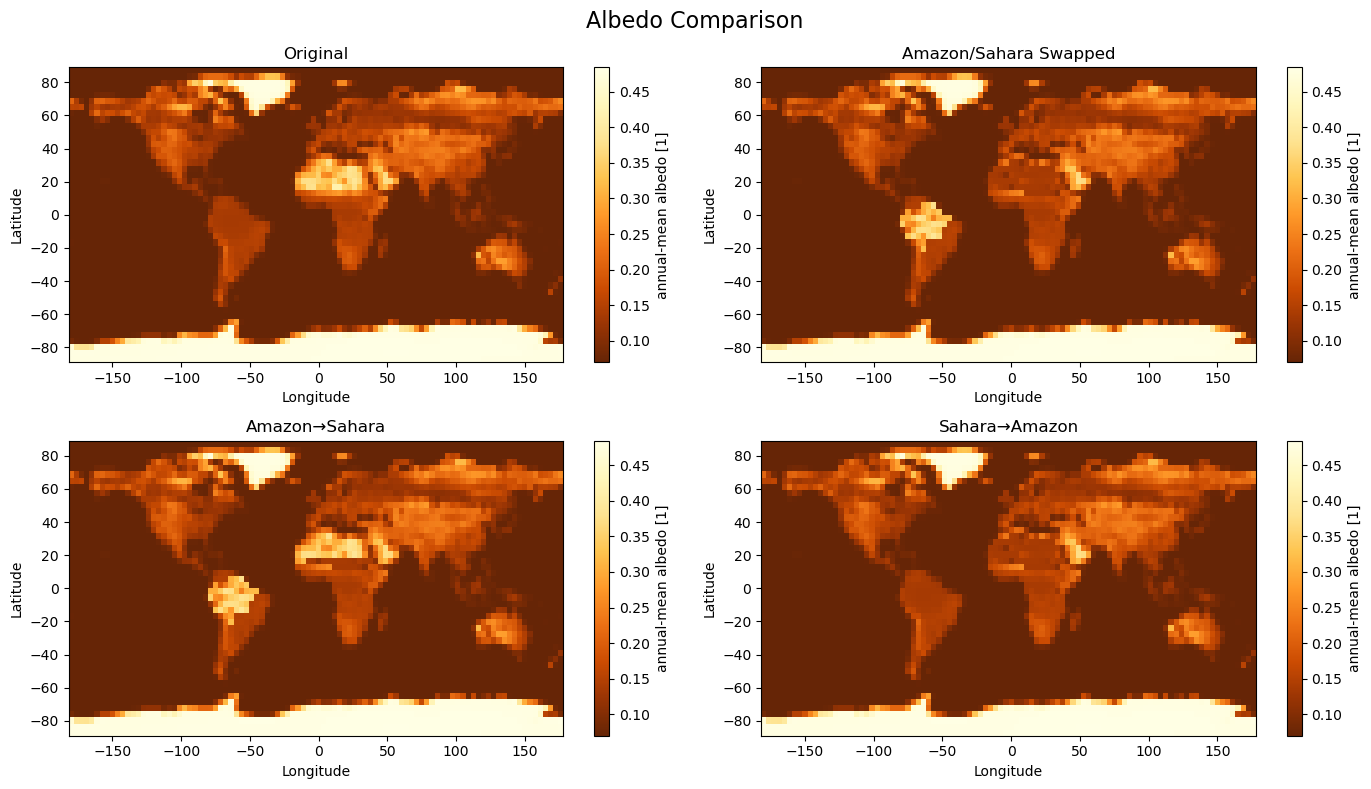

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

alb_datasets = [
    (ds_alb_0360, 'Original'),
    (ds_alb_swap, 'Amazon/Sahara Swapped'),
    (ds_alb_sahara2, 'Amazon→Sahara'),
    (ds_alb_amazon2, 'Sahara→Amazon')
]

for ax, (ds, title) in zip(axs.flat, alb_datasets):
    ds.alb.plot(ax=ax, cmap='YlOrBr_r')
    ax.set_title(title)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

fig.suptitle('Albedo Comparison', fontsize=16)
plt.tight_layout()
plt.show()